<a href="https://colab.research.google.com/github/devasree09/phishing-url-detection-/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving malicious_phish (2).csv to malicious_phish (2).csv


In [ ]:
!pip install streamlit xgboost tensorflow scikit-learn pyngrok tldextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import re
from urllib.parse import urlparse

#Load and Prepare Data
df = pd.read_csv('malicious_phish (2).csv').dropna()
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

#Feature Extraction from URL
def extract_features(url):
    parsed = urlparse(url)
    features = {
        'url_length': len(url),
        'num_digits': sum(c.isdigit() for c in url),
        'num_special_char': len(re.findall(r'\W', url)),
        'num_dots': url.count('.'),
        'has_https': int(url.startswith('https')),
        'has_ip': int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url))),
        'path_length': len(parsed.path),
        'domain_length': len(parsed.netloc)
    }
    return features

feature_df = df['url'].apply(extract_features).apply(pd.Series)
X = feature_df
y = df['type']

# Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ANN Model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes
])
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# ANN Predictions
ann_preds_prob = ann_model.predict(X_test)
ann_preds = np.argmax(ann_preds_prob, axis=1)
print("\n🔹 ANN Classification Report:\n", classification_report(y_test, ann_preds))
print("🔹 ANN Accuracy:", accuracy_score(y_test, ann_preds))

#  XGBoost Model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, objective='multi:softmax', num_class=4)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("\n🔹 XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))
print("🔹 XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))

#Soft Voting Ensemble
from sklearn.base import BaseEstimator, ClassifierMixin

class ANNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        preds = self.model.predict(X)
        return np.argmax(preds, axis=1)

ann_clf = ANNWrapper(ann_model)

voting_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('ann', ann_clf)
], voting='soft')

ensemble_preds = voting_model.predict(X_test)
print("\n🔹 Ensemble Classification Report:\n", classification_report(y_test, ensemble_preds))
print("🔹 Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.8398 - loss: 0.4179 - val_accuracy: 0.8795 - val_loss: 0.3093
Epoch 2/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - accuracy: 0.8771 - loss: 0.3254 - val_accuracy: 0.8871 - val_loss: 0.2922
Epoch 3/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.8827 - loss: 0.3114 - val_accuracy: 0.8914 - val_loss: 0.2841
Epoch 4/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 0.8838 - loss: 0.3072 - val_accuracy: 0.8951 - val_loss: 0.2793
Epoch 5/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.8851 - loss: 0.3038 - val_accuracy: 0.8938 - val_loss: 0.2781
Epoch 6/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.8866 - loss: 0.3014 - val_accuracy: 0.8947 - val_loss: 0.2736
Epoch 7/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.8880 - loss: 0.2973 - val_accuracy: 0.8955 - val_loss: 0.2723
Epoch 8/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 

NotFittedError: This VotingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<ipython-input-10-61ca1595ffc3>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='coolwarm')


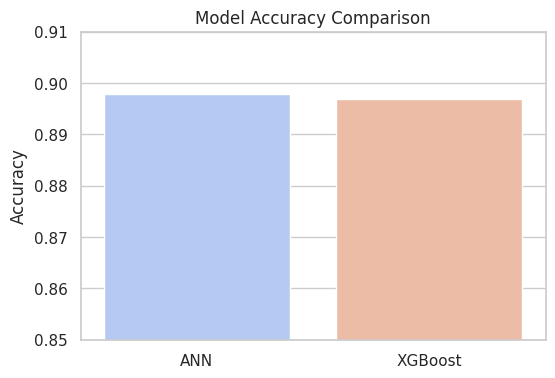

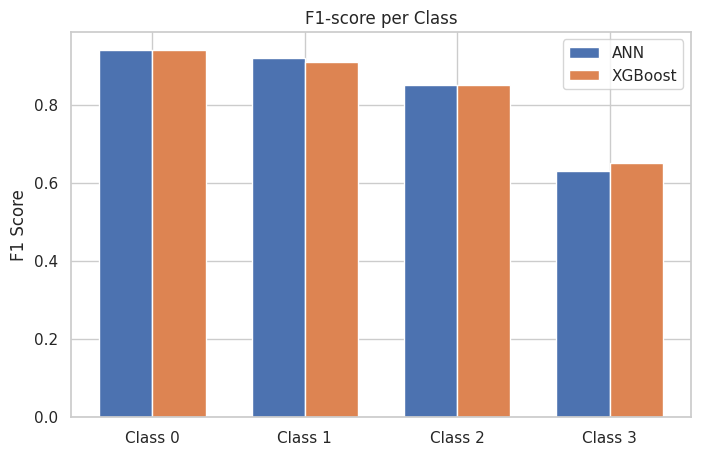

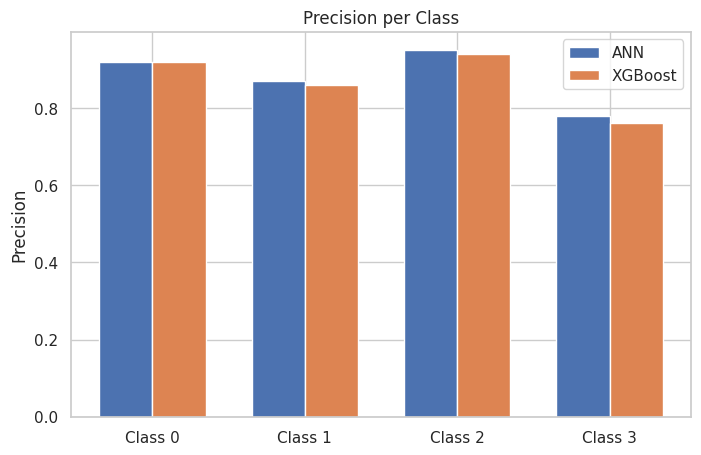

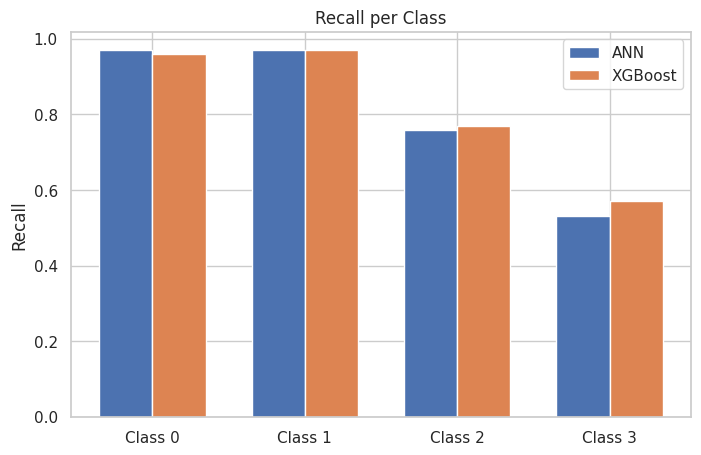

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Accuracy values
models = ['ANN', 'XGBoost']
accuracies = [0.8979, 0.8970]

# F1-score per class
f1_scores_ann = [0.94, 0.92, 0.85, 0.63]
f1_scores_xgb = [0.94, 0.91, 0.85, 0.65]
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Precision and recall per class
precision_ann = [0.92, 0.87, 0.95, 0.78]
recall_ann = [0.97, 0.97, 0.76, 0.53]

precision_xgb = [0.92, 0.86, 0.94, 0.76]
recall_xgb = [0.96, 0.97, 0.77, 0.57]

# 1. Accuracy Bar Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies, palette='coolwarm')
plt.ylim(0.85, 0.91)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

# 2. F1-score per class
x = np.arange(len(classes))
width = 0.35
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, f1_scores_ann, width, label='ANN')
plt.bar(x + width/2, f1_scores_xgb, width, label='XGBoost')
plt.xticks(x, classes)
plt.ylabel('F1 Score')
plt.title('F1-score per Class')
plt.legend()
plt.show()

# 3. Precision and Recall per class (Grouped)
metrics = ['Precision', 'Recall']
for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    ann_vals = precision_ann if metric == 'Precision' else recall_ann
    xgb_vals = precision_xgb if metric == 'Precision' else recall_xgb
    x = np.arange(len(classes))
    plt.bar(x - width/2, ann_vals, width, label='ANN')
    plt.bar(x + width/2, xgb_vals, width, label='XGBoost')
    plt.xticks(x, classes)
    plt.ylabel(metric)
    plt.title(f'{metric} per Class')
    plt.legend()
    plt.show()
